# In this notebook I will test out and understand code to read in datasets from the READ 2016 and READ ICFHR 2018 data

In [1]:
import sys  
stdout = sys.stdout
reload(sys)  
sys.setdefaultencoding('utf-8')
sys.stdout = stdout
#from model_error import cer, wer

In [2]:
from lxml import objectify
import os
import lmdb # install lmdb by "pip install lmdb"
import cv2
import numpy as np
import re

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np


def page_images(data_folder):

    images = []

    images_dir =os.path.join(data_folder,'Images')
    xml_dir = os.path.join(data_folder,'page')

    xml_files = [os.path.join(xml_dir,f) for f in os.listdir(xml_dir)]
    images_files = [os.path.join(images_dir,f) for f in os.listdir(images_dir)]

    for xml in xml_files:
        print xml
        file  = open(xml)
        xml_string = file.read()
        page = objectify.fromstring(xml_string) # convert from xml string to "python type object"

        images.append(page)

    return images

def rgb(img):
    b,g,r = cv2.split(img)
    rgb_img = cv2.merge([r,g,b])
    return rgb_img

In [3]:
data_folder = "/home/ubuntu/datasets/read_curtis/Training-small"

images = page_images(data_folder)

/home/ubuntu/datasets/read_curtis/Training-small/page/Seite0017.xml
/home/ubuntu/datasets/read_curtis/Training-small/page/Seite0144.xml
/home/ubuntu/datasets/read_curtis/Training-small/page/Seite0316.xml
/home/ubuntu/datasets/read_curtis/Training-small/page/Seite0347.xml
/home/ubuntu/datasets/read_curtis/Training-small/page/Seite0074.xml
/home/ubuntu/datasets/read_curtis/Training-small/page/Seite0177.xml
/home/ubuntu/datasets/read_curtis/Training-small/page/Seite0256.xml
/home/ubuntu/datasets/read_curtis/Training-small/page/Seite0128.xml
/home/ubuntu/datasets/read_curtis/Training-small/page/Seite0068.xml
/home/ubuntu/datasets/read_curtis/Training-small/page/Seite0047.xml
/home/ubuntu/datasets/read_curtis/Training-small/page/Seite0322.xml
/home/ubuntu/datasets/read_curtis/Training-small/page/Seite0182.xml
/home/ubuntu/datasets/read_curtis/Training-small/page/Seite0080.xml
/home/ubuntu/datasets/read_curtis/Training-small/page/Seite0291.xml
/home/ubuntu/datasets/read_curtis/Training-small

### I am walking through this code one step at a time with the first image "Seite0017.JPG"

In [19]:
images[0].Page.get('imageFilename')

'Seite0017.JPG'

In [5]:
img_data  = cv2.imread(os.path.join(data_folder, "Images", images[0].Page.get('imageFilename')))

In [6]:
test_img = mpimg.imread(os.path.join(data_folder, "Images", images[0].Page.get('imageFilename'))).astype('uint8')

In [12]:
img_data.shape

NameError: name 'img_data' is not defined

In [8]:
np.version.version

'1.10.4'

In [9]:
# This works great! I can use this or encapsulate it into a function as necessary for displaying the line images
b,g,r = cv2.split(img_data)       # get b,g,r
rgb_img = cv2.merge([r,g,b]) 

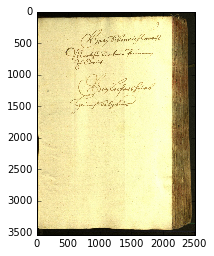

In [10]:
plt.imshow(rgb(img_data))

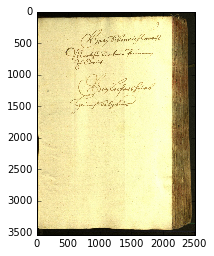

In [11]:
plt.imshow(test_img)

In [12]:
images[0].Page.TextRegion

<Element {http://schema.primaresearch.org/PAGE/gts/pagecontent/2013-07-15}TextRegion at 0x7fd1bb0d2dd0>

I need to load matplotlib so that I can draw the pictures that I take from this photo


In [13]:
(255,) * 1

(255,)

{http://schema.primaresearch.org/PAGE/gts/pagecontent/2013-07-15}TextRegion
{http://schema.primaresearch.org/PAGE/gts/pagecontent/2013-07-15}TextRegion


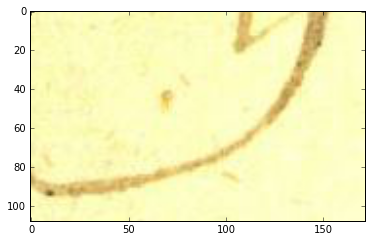

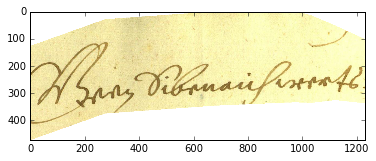

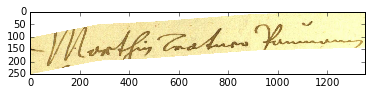

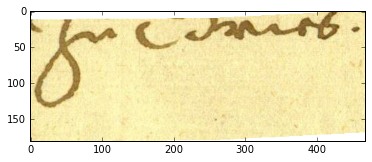

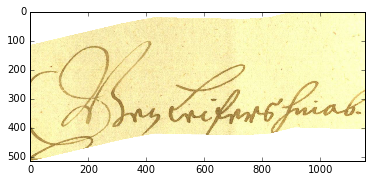

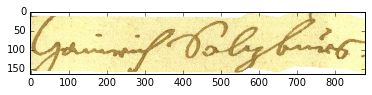

In [14]:


i = 0
for region in images[0].Page.TextRegion:
    print str(region.tag)
    
    line_tags = [c.tag.split('}')[1] for c in region.getchildren()]
    for line in region.TextLine:
        #print 'line ' + line.get('id')
        data = line.Coords.get('points')
        pts = [tuple(int(x) for x in v.split(',')) for v in data.split()]
        pts = np.array(pts, np.int32)
        xmin = min(pts, key=lambda x: x[0])[0]
        xmax = max(pts, key=lambda x: x[0])[0]
        
        ymin = min(pts, key=lambda x: x[1])[1]
        ymax = max(pts, key=lambda x: x[1])[1]
        
        updated_pts = [(p[0] - xmin, p[1] - ymin) for p in pts]
        line_img = img_data[ymin:ymax, xmin:xmax].copy()
        
        mask = np.zeros(line_img.shape, dtype=np.uint8)
        
        roi_corners = np.array([updated_pts], dtype=np.int32)
        channel_count = 1
        if len(line_img.shape) > 2:
            channel_count = line_img.shape[2]
        
        ignore_mask_color = (255,) * channel_count
        cv2.fillPoly(mask, roi_corners, ignore_mask_color)
        line_img[mask == 0] = 255
        imageBin = cv2.imencode('.png', line_img)[1].tostring()
        #print(imageBin)
        
        #mask = np.zeros(line_img.shape, dtype=np.uint8)
        #            roi_corners = np.array([updated_pts], dtype=np.int32)

        #            channel_count = 1
        #            if len(line_img.shape) > 2:
        #                channel_count = line_img.shape[2]

        #            ignore_mask_color = (255,) * channel_count
        #            cv2.fillPoly(mask, roi_corners, ignore_mask_color)
        #            line_img[mask == 0] = 255
                    # line['data'] = line_img
        #            imageBin = cv2.imencode('.png', line_img)[1].tostring()
        
        #plt.imshow(rgb(line_img))
        i = i + 1
        plt.imshow(rgb(line_img))
        plt.figure(i+1)
        
plt.show()
        

### Now I am going to write code to interface with the files that we have for the 2018 ICFHR Data

In [5]:
img_file = "/home/ubuntu/datasets/read_ICFHR/general_data/30865/Konzilsprotokolle_B/30865_0011_1063536_r2_r2l1.jpg"
info_file = "/home/ubuntu/datasets/read_ICFHR/general_data/30865/Konzilsprotokolle_B/30865_0011_1063536_r2_r2l1.jpg.info"
text_file = "/home/ubuntu/datasets/read_ICFHR/general_data/30865/Konzilsprotokolle_B/30865_0011_1063536_r2_r2l1.jpg.txt"

info = ""
gt = ""
with open(text_file, 'r') as myfile:
        gt = myfile.read()
#label = gt.encode('utf-8')
l = "sich dadurch nicht des ihnen schon vormals zugedachten Ver¬"

In [5]:
# Pseudocode for this,
# Refactor this all with good functions to help in making the code more versatile

# Do later: Grab a list of every .jpg file in the subdirectory 
# Do later: for each file
# Do now:
#     Grab the info and txt files as well as the jpg image
#     Find the mask in the info file
#     Apply the mask to the jpg image
#     put the masked jpg and the ground truth in the lmdb database

In [6]:
!ls -R /home/ubuntu/datasets/read_ICFHR/general_data/ | grep ".jpg$" | wc

  11925   11925  666124


### This works perfectly to apply the mask to each image. Now I need to incorporate it into the reading code.

11925


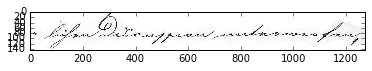

In [7]:
from glob import glob
p_dir = "/home/ubuntu/datasets/read_ICFHR/general_data/"
img_m = ""
count = 0
for img_file in glob(os.path.join(p_dir, "*/*/*.jpg")):
    img_c = cv2.imread(img_file)
    info_file = img_file + ".info" 
    text_file = img_file + ".txt"
    with open(info_file, "r") as i_f, open(text_file, "r") as t_f:
        info = i_f.read()
        gt = t_f.read()

        mask = info.partition("MASK\n")[2]


        myre = re.compile(r"[0-9]+,[0-9]+")
        mask_p = myre.findall(mask)
        mask_pts = [tuple(int(x) for x in v.split(',')) for v in mask_p]
        img_m = apply_mask(img_c, mask_pts)
        #plt.imshow(rgb(img_m))
    #print(f)
    count = count + 1
    
plt.imshow(rgb(img_m))
print(count)

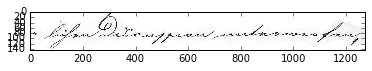

In [10]:
plt.imshow(rgb(img_m))

In [ ]:
img_c  = cv2.imread(img_file)
with open(info_file, "r") as i_f, open(text_file, "r") as t_f:
    info = i_f.read()
    gt = t_f.read()
    
    mask = info.partition("MASK\n")[2]
    
   
    myre = re.compile(r"[0-9]+,[0-9]+")
    mask_p = myre.findall(mask)
    mask_pts = [tuple(int(x) for x in v.split(',')) for v in mask_p]
    img_m = apply_mask(img_c, mask_pts)
    plt.imshow(rgb(img_m))
    #print(pts)
    #print(mask)
    #print(mask_p)
    #mask_p = mask.replace("")
    
    
    # show the masked image
    
    
    #print(info)
    #print(gt)
    #print(part[2])

In [4]:
def apply_mask(img, pts):
    
    pts = np.array(pts, np.int32)

    xmin = min(pts, key=lambda x: x[0])[0]
    xmax = max(pts, key=lambda x: x[0])[0]

    ymin = min(pts, key=lambda x: x[1])[1]
    ymax = max(pts, key=lambda x: x[1])[1]
    updated_pts = [(p[0] - xmin, p[1] - ymin) for p in pts]
    line_img = img[ymin:ymax, xmin:xmax].copy()
    mask = np.zeros(line_img.shape, dtype=np.uint8)

    roi_corners = np.array([updated_pts], dtype=np.int32)
    channel_count = 1
    if len(line_img.shape) > 2:
        channel_count = line_img.shape[2]

    ignore_mask_color = (255,) * channel_count
    cv2.fillPoly(mask, roi_corners, ignore_mask_color)
    line_img[mask == 0] = 255
    
    return line_img
        
        
        

In [ ]:
        
        pts = [tuple(int(x) for x in v.split(',')) for v in data.split()]
        pts = np.array(pts, np.int32)
        
        
        
        
        
        imageBin = cv2.imencode('.png', line_img)[1].tostring()
        #print(imageBin)
        
        #mask = np.zeros(line_img.shape, dtype=np.uint8)
        #            roi_corners = np.array([updated_pts], dtype=np.int32)

        #            channel_count = 1
        #            if len(line_img.shape) > 2:
        #                channel_count = line_img.shape[2]

        #            ignore_mask_color = (255,) * channel_count
        #            cv2.fillPoly(mask, roi_corners, ignore_mask_color)
        #            line_img[mask == 0] = 255
                    # line['data'] = line_img
        #            imageBin = cv2.imencode('.png', line_img)[1].tostring()
        
        #plt.imshow(rgb(line_img))
        i = i + 1
        plt.imshow(rgb(line_img))
        plt.figure(i+1)
        
plt.show()
        

# This code works for a single example. Now I need to scale it up for all examples and work it into our create dataset code. It's almost ready.

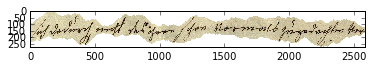

In [8]:
img_c  = cv2.imread(img_file)
with open(info_file, "r") as i_f, open(text_file, "r") as t_f:
    info = i_f.read()
    gt = t_f.read()
    
    mask = info.partition("MASK\n")[2]
    
   
    myre = re.compile(r"[0-9]+,[0-9]+")
    mask_p = myre.findall(mask)
    mask_pts = [tuple(int(x) for x in v.split(',')) for v in mask_p]
    img_m = apply_mask(img_c, mask_pts)
    plt.imshow(rgb(img_m))
    #print(pts)
    #print(mask)
    #print(mask_p)
    #mask_p = mask.replace("")
    
    
    # show the masked image
    
    
    #print(info)
    #print(gt)
    #print(part[2])

In [26]:
print("sich dadurch nicht des ihnen schon vormals zugedachten Ver¬")

sich dadurch nicht des ihnen schon vormals zugedachten Ver¬


In [ ]:
def lmdb_dataset_read(data_dir, output_path):

    env = lmdb.open(output_path, map_size=1099511627776)
    images = page_images(data_dir)
    # print images

    cache = {}
    cnt = 1

    alpha_text = '0123456789abcdefghijklmnopqrstuvwxyz'
    alphabet = []
    for c in alpha_text:
        alphabet.append(c)


    for image in images:
        print image
        file_image = os.path.join(data_dir,'Images',image.Page.get('imageFilename'))
        image['data'] = cv2.imread(file_image)
        page_img = cv2.imread(file_image)
        # page_img = image['data']

        for region in image.Page.TextRegion:
            print 'region'
            print str(region.tag)

            line_tags = [c.tag.split('}')[1] for c in region.getchildren()]

            if any('TextLine' in l for l in line_tags):
                for line in region.TextLine:
                    print 'line '+line.get('id')
                    print str(line.Coords.get('points'))
                    data = line.Coords.get('points')
                    pts = [tuple(int(x) for x in v.split(',')) for v in data.split()]
                    pts = np.array(pts, np.int32)
                    xmin = min(pts, key=lambda x: x[0])[0]
                    xmax = max(pts, key=lambda x: x[0])[0]

                    ymin = min(pts, key=lambda x: x[1])[1]
                    ymax = max(pts, key=lambda x: x[1])[1]

                    updated_pts = [(p[0] - xmin, p[1] - ymin) for p in pts]
                    line_img = page_img[ymin:ymax, xmin:xmax].copy()
                    # http://stackoverflow.com/a/15343106/3479446
                    mask = np.zeros(line_img.shape, dtype=np.uint8)
                    roi_corners = np.array([updated_pts], dtype=np.int32)

                    channel_count = 1
                    if len(line_img.shape) > 2:
                        channel_count = line_img.shape[2]

                    ignore_mask_color = (255,) * channel_count
                    cv2.fillPoly(mask, roi_corners, ignore_mask_color)
                    line_img[mask == 0] = 255
                    # line['data'] = line_img
                    imageBin = cv2.imencode('.png', line_img)[1].tostring()
                    # imageBin = cv2.imencode('.png', line['data'])[1].tostring()

                    if not checkImageIsValid(imageBin):
                        print('%s is not a valid image' % image['image_file'])
                        continue

                    annotation = line.TextEquiv.Unicode.text

                    # label = annotation.encode('utf-8')

                    label = annotation.encode('utf-8')

                    for c in label:
                        if not c in alphabet:
                            alphabet.append(c)

                    # if not label.isalnum():
                    #     print label
                    #     sys.exit(0)

                    imageKey = 'image-%09d' % cnt
                    labelKey = 'label-%09d' % cnt

                    print imageKey

                    cache[imageKey] = imageBin
                    cache[labelKey] = label
                    if cnt % 1000 == 0:
                        writeCache(env, cache)
                        cache = {}
                        print('Written %d' % (cnt))

                    line['database_id'] = cnt

                    cnt += 1

    nSamples = cnt - 1
    cache['num-samples'] = str(nSamples)
    writeCache(env, cache)
    print('Created dataset with %d samples' % nSamples)

    alpha_text = ''.join(alphabet)

    with open("alphabet.txt", "w") as text_file:
        text_file.write(alpha_text)
